In [32]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [41]:
# Define the root directory
root_dir = "C:\\Users\\henak\\OneDrive\\Desktop\\Source Code Classification\\Algorithm Dataset"

data = []

In [3]:
# Traverse the directory
for category in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory (category: graphs, searching, sorting)
        for algorithm in os.listdir(category_path):
            algorithm_path = os.path.join(category_path, algorithm)
            if os.path.isdir(algorithm_path):  # Ensure it's a directory (algorithm: BFS, Dijkstra, etc.)
                for language in os.listdir(algorithm_path):
                    language_path = os.path.join(algorithm_path, language)
                    if os.path.isdir(language_path):  # Ensure it's a directory (language: C, Java, etc.)
                        for file in os.listdir(language_path):
                            file_path = os.path.join(language_path, file)
                            if os.path.isfile(file_path):  # Ensure it's a file
                                try:
                                    # Read file content
                                    with open(file_path, 'r', encoding='utf-8') as f:
                                        content = f.read()
                                    # Append to data
                                    data.append({
                                        "category": category,  # Category: graphs, searching, sorting
                                        "algorithm": algorithm,  # Algorithm: BFS, Dijkstra, etc.
                                        "language": language,  # Language: C, Java, Python, etc.
                                        "file_name": file,  # File name
                                        "content": content  # Source code content
                                    })
                                except Exception as e:
                                    print(f"Error reading {file_path}: {e}")
                            else:
                                print(f"Skipping non-file: {file_path}")

In [4]:
# Convert to a DataFrame
df = pd.DataFrame(data)
df.head()

,category,algorithm,language,file_name,content
0,graphs,Bellman-Ford Algorithm,C,Bellman-Ford Algorithm_1.c,/* ===== ===== =====\n\nTheory of Programming\...
1,graphs,Bellman-Ford Algorithm,C,Bellman-Ford Algorithm_10.c,/* file: bfa.c\n author: David De Potter\n ...
2,graphs,Bellman-Ford Algorithm,C,Bellman-Ford Algorithm_100.c,#ifndef LEPL1503__GRAPH__\n#define LEPL1503__G...
3,graphs,Bellman-Ford Algorithm,C,Bellman-Ford Algorithm_101.c,/* ===== ===== =====\n\nTheory of Programming\...
4,graphs,Bellman-Ford Algorithm,C,Bellman-Ford Algorithm_102.c,//--------------------------------------------...


C:\Users\henak\AppData\Local\Temp\ipykernel_11336\860456636.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


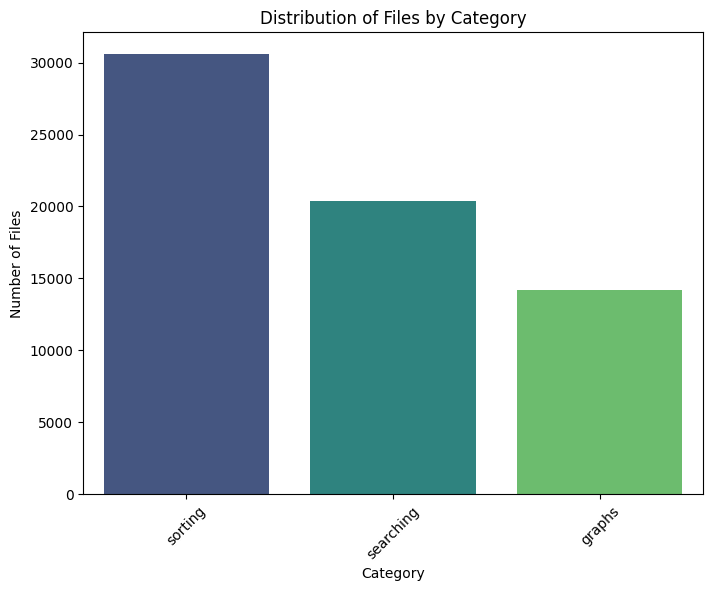

In [33]:
category_counts = df['category'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Files by Category')
plt.xlabel('Category')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.show()

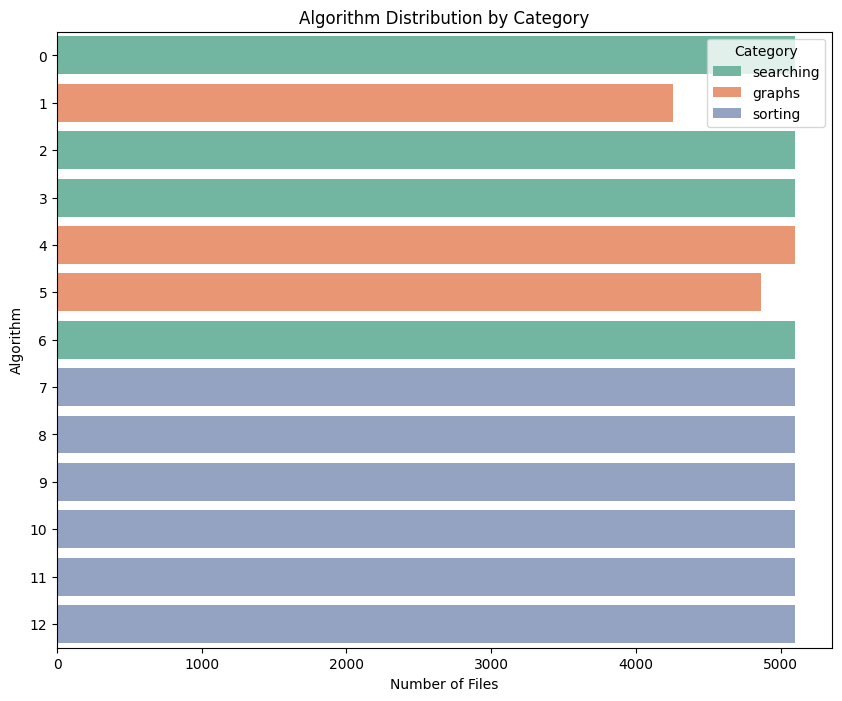

In [34]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, y='algorithm', hue='category', palette='Set2')
plt.title('Algorithm Distribution by Category')
plt.xlabel('Number of Files')
plt.ylabel('Algorithm')
plt.legend(title='Category')
plt.show()


C:\Users\henak\AppData\Local\Temp\ipykernel_11336\3962241197.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.index, y=language_counts.values, palette='coolwarm')


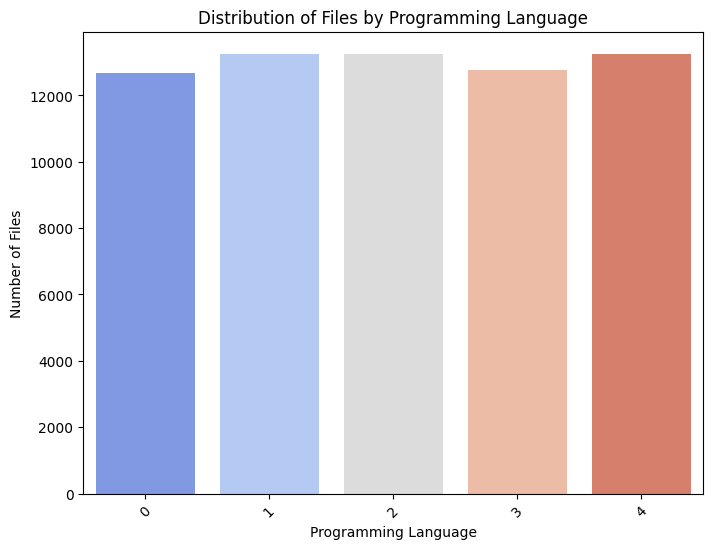

In [35]:
language_counts = df['language'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='coolwarm')
plt.title('Distribution of Files by Programming Language')
plt.xlabel('Programming Language')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.show()


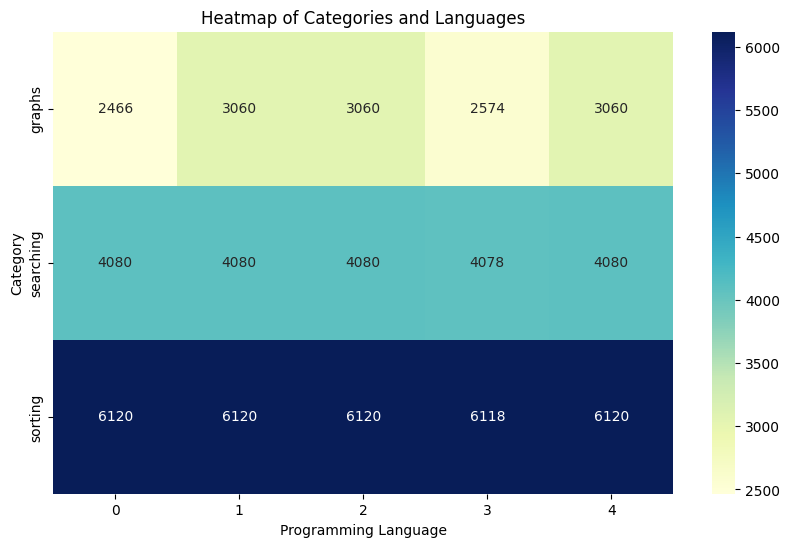

In [36]:
pivot_table = df.pivot_table(index='category', columns='language', aggfunc='size', fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Categories and Languages')
plt.xlabel('Programming Language')
plt.ylabel('Category')
plt.show()


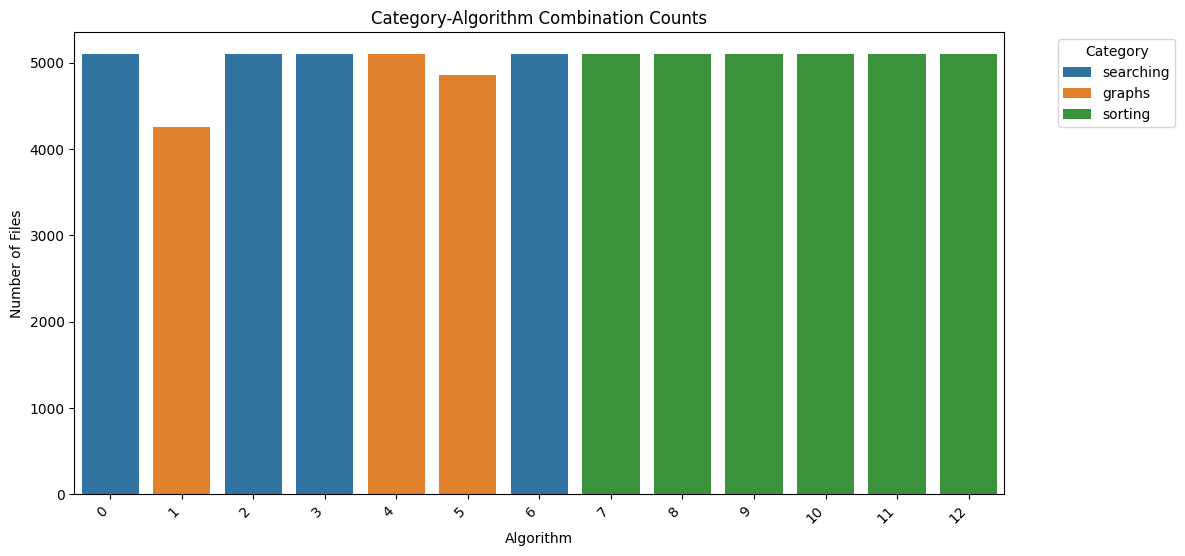

In [39]:
combo_counts = df.groupby(['category', 'algorithm']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(data=combo_counts, x='algorithm', y='count', hue='category', dodge=False, palette='tab10')
plt.title('Category-Algorithm Combination Counts')
plt.xlabel('Algorithm')
plt.ylabel('Number of Files')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [5]:
# Tokenize the text data
MAX_VOCAB_SIZE = 20000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 500  # Maximum sequence length

In [6]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [7]:
# Encode labels
algorithm_encoder = LabelEncoder()
language_encoder = LabelEncoder()

df['algorithm'] = algorithm_encoder.fit_transform(df['algorithm'])
df['language'] = language_encoder.fit_transform(df['language'])

In [8]:
X_train, X_test, y_train_algo, y_test_algo = train_test_split(
    padded_sequences, df['algorithm'], test_size=0.2, random_state=42)

_, _, y_train_lang, y_test_lang = train_test_split(
    padded_sequences, df['language'], test_size=0.2, random_state=42)

In [9]:
# Input layer
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), name="input")

# Embedding layer
embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH, name="embedding")(input_layer)

# LSTM layers with bidirectional configuration
lstm_layer = Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.2), name="bidirectional_lstm")(embedding_layer)

# Fully connected layers
dense_layer_1 = Dense(128, activation='relu', name="dense_1")(lstm_layer)
batch_norm_1 = BatchNormalization(name="batch_norm_1")(dense_layer_1)
dropout_1 = Dropout(0.4, name="dropout_1")(batch_norm_1)

# Output for algorithm classification
output_algo = Dense(len(df['algorithm'].unique()), activation='softmax', name="algorithm_output")(dropout_1)

# Output for language classification
dense_layer_2 = Dense(128, activation='relu', name="dense_2")(dropout_1)
output_lang = Dense(len(df['language'].unique()), activation='softmax', name="language_output")(dense_layer_2)

# Define model
model = Model(inputs=input_layer, outputs=[output_algo, output_lang])


c:\Users\henak\OneDrive\Desktop\Source Code Classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'algorithm_output': 'sparse_categorical_crossentropy', 'language_output': 'sparse_categorical_crossentropy'},
    metrics={'algorithm_output': 'accuracy', 'language_output': 'accuracy'}
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 500)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 128)  │  2,560,000 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ bidirectional_ls… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_norm_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ algorithm_output    │ (None, 13)        │      1,677 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ language_output     │ (None, 5)         │        645 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,875,410 (10.97 MB)

 Trainable params: 2,875,154 (10.97 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Early stopping and learning rate scheduler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, {'algorithm_output': y_train_algo, 'language_output': y_train_lang},
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/15
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 1049s 791ms/step - algorithm_output_accuracy: 0.2181 - algorithm_output_loss: 2.2939 - language_output_accuracy: 0.6840 - language_output_loss: 0.8050 - loss: 3.0989 - val_algorithm_output_accuracy: 0.4331 - val_algorithm_output_loss: 1.6790 - val_language_output_accuracy: 0.8862 - val_language_output_loss: 0.3274 - val_loss: 2.0060 - learning_rate: 0.0010
Epoch 2/15
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 1010s 774ms/step - algorithm_output_accuracy: 0.4517 - algorithm_output_loss: 1.6529 - language_output_accuracy: 0.8834 - language_output_loss: 0.3477 - loss: 2.0006 - val_algorithm_output_accuracy: 0.5196 - val_algorithm_output_loss: 1.4831 - val_language_output_accuracy: 0.9077 - val_language_output_loss: 0.2678 - val_loss: 1.7528 - learning_rate: 0.0010
Epoch 3/15
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 1024s 784ms/step - algorithm_output_accuracy: 0.5651 - algorithm_output_loss: 1.3416 - language_output_accuracy: 0.9199 - language_output_loss: 0.2453 - los

In [12]:
# Train model
history = model.fit(
    X_train, {'algorithm_output': y_train_algo, 'language_output': y_train_lang},
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 825s 632ms/step - algorithm_output_accuracy: 0.8415 - algorithm_output_loss: 0.4862 - language_output_accuracy: 0.9836 - language_output_loss: 0.0545 - loss: 0.5407 - val_algorithm_output_accuracy: 0.7224 - val_algorithm_output_loss: 0.9933 - val_language_output_accuracy: 0.9698 - val_language_output_loss: 0.1201 - val_loss: 1.1159 - learning_rate: 5.0000e-04
Epoch 2/5
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 970s 715ms/step - algorithm_output_accuracy: 0.8576 - algorithm_output_loss: 0.4050 - language_output_accuracy: 0.9885 - language_output_loss: 0.0413 - loss: 0.4463 - val_algorithm_output_accuracy: 0.7182 - val_algorithm_output_loss: 1.0478 - val_language_output_accuracy: 0.9736 - val_language_output_loss: 0.1183 - val_loss: 1.1691 - learning_rate: 5.0000e-04
Epoch 3/5
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 896s 687ms/step - algorithm_output_accuracy: 0.8699 - algorithm_output_loss: 0.3614 - language_output_accuracy: 0.9909 - language_output_loss: 0.0342 - l

In [13]:
results = model.evaluate(
    X_test,
    {'algorithm_output': y_test_algo, 'language_output': y_test_lang}
)

print("Test Accuracy and Loss for Algorithm Classification:", results[1:3])
print("Test Accuracy and Loss for Language Classification:", results[3:])


408/408 ━━━━━━━━━━━━━━━━━━━━ 96s 234ms/step - algorithm_output_accuracy: 0.7134 - algorithm_output_loss: 1.0404 - language_output_accuracy: 0.9715 - language_output_loss: 0.1223 - loss: 1.1626
Test Accuracy and Loss for Algorithm Classification: [1.0365318059921265, 0.11521530896425247]
Test Accuracy and Loss for Language Classification: [0.7140447497367859, 0.9721711277961731]


In [14]:
# Example code snippet
example_code = '''def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        # Flag to optimize if no swap is made
        swapped = False
        for j in range(0, n - i - 1):
            if arr[j] > arr[j + 1]:
                # Swap if elements are in wrong order
                arr[j], arr[j + 1] = arr[j + 1], arr[j]
                swapped = True
        # If no two elements were swapped, the array is sorted
        if not swapped:
            break
    return arr

# Example usage
arr = [64, 34, 25, 12, 22, 11, 90]
print("Sorted array:", bubble_sort(arr))

'''

# Preprocess the code snippet
example_sequence = tokenizer.texts_to_sequences([example_code])
example_padded = pad_sequences(example_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Predict
predictions = model.predict(example_padded)
predicted_algorithm = algorithm_encoder.inverse_transform([predictions[0].argmax()])
predicted_language = language_encoder.inverse_transform([predictions[1].argmax()])

print("Predicted Algorithm:", predicted_algorithm[0])
print("Predicted Language:", predicted_language[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Algorithm: bubble sort
Predicted Language: Python


In [23]:
# Extracting training and validation accuracy and loss from history
train_accuracy_algo = history.history['algorithm_output_accuracy']  # Training accuracy for algorithm output
val_accuracy_algo = history.history['val_algorithm_output_accuracy']  # Validation accuracy for algorithm output

train_accuracy_lang = history.history['language_output_accuracy']  # Training accuracy for language output
val_accuracy_lang = history.history['val_language_output_accuracy']  # Validation accuracy for language output

train_loss = history.history['loss']  # Total training loss
val_loss = history.history['val_loss']

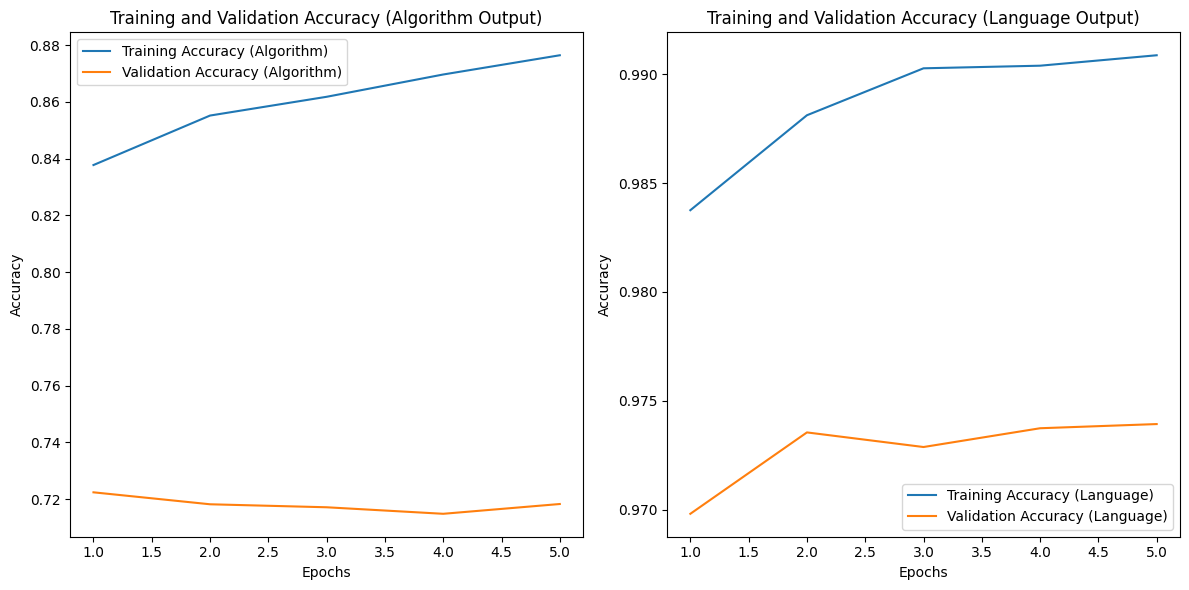

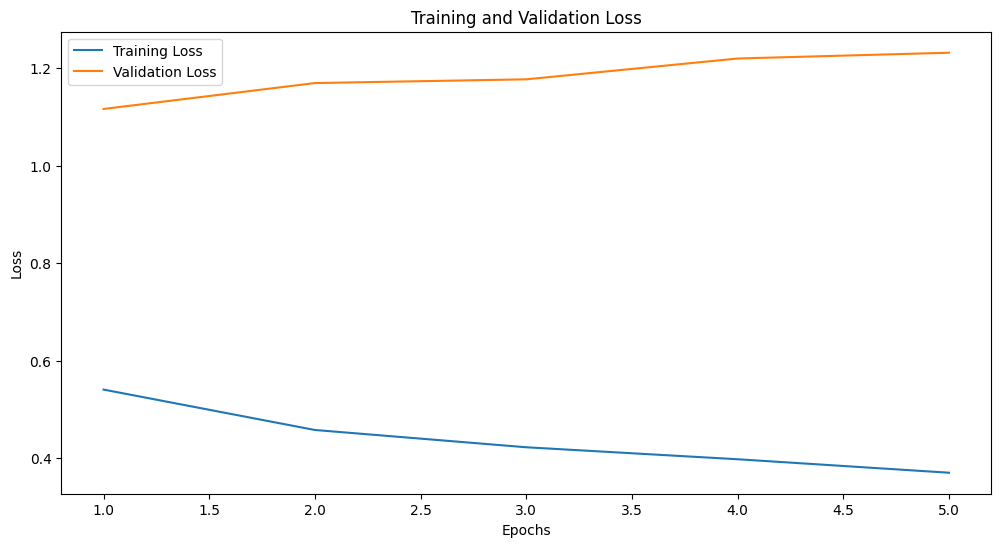

In [24]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy for algorithm output
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracy_algo) + 1), train_accuracy_algo, label='Training Accuracy (Algorithm)')
plt.plot(range(1, len(val_accuracy_algo) + 1), val_accuracy_algo, label='Validation Accuracy (Algorithm)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Algorithm Output)')
plt.legend()

# Plot accuracy for language output
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy_lang) + 1), train_accuracy_lang, label='Training Accuracy (Language)')
plt.plot(range(1, len(val_accuracy_lang) + 1), val_accuracy_lang, label='Validation Accuracy (Language)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Language Output)')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

408/408 ━━━━━━━━━━━━━━━━━━━━ 45s 109ms/step


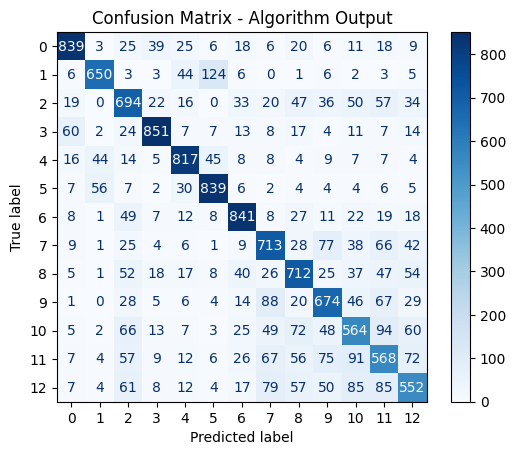

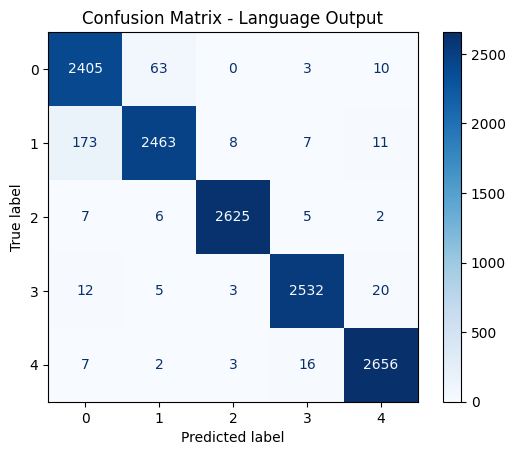

In [30]:
# Predict on the test set
predictions = model.predict(X_test)

# Assuming predictions is a list with outputs in the same order as model outputs
y_pred_algo = np.argmax(predictions[0], axis=1)  # First output: Algorithm predictions
y_pred_lang = np.argmax(predictions[1], axis=1)  # Second output: Language predictions

# True labels (already in label format, no need for np.argmax)
y_true_algo = y_test_algo
y_true_lang = y_test_lang

# Generate confusion matrices
cm_algo = confusion_matrix(y_true_algo, y_pred_algo)
cm_lang = confusion_matrix(y_true_lang, y_pred_lang)

# Plot confusion matrix for algorithm output
disp_algo = ConfusionMatrixDisplay(confusion_matrix=cm_algo, display_labels=np.unique(y_true_algo))
disp_algo.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Algorithm Output')
plt.show()

# Plot confusion matrix for language output
disp_lang = ConfusionMatrixDisplay(confusion_matrix=cm_lang, display_labels=np.unique(y_true_lang))
disp_lang.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Language Output')
plt.show()